<a href="https://colab.research.google.com/github/intelligent-environments-lab/occupant_centric_grid_interactive_buildings_course/blob/main/src/notebooks/homework/homework_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5: _"Buildings don't use energy, people do" - Kathryn B. Janda (2011)_
---

In this homework, you will use the schedules you generated in [homework 4](https://github.com/intelligent-environments-lab/occupant_centric_grid_interactive_buildings_course/blob/main/src/notebooks/homework/Homework_4.ipynb) to change the occupancy, lighting and electric equipment schedules in office spaces in a building similar to the data source building in [Modeling occupancy in single person offices](https://www.sciencedirect.com/science/article/abs/pii/S0378778804001951) (Wang et al., 2005). The building is an EnergyPlus model in the [End-Use Load Profiles (EULP) for the U.S. Building Stock](https://www.nrel.gov/buildings/end-use-load-profiles.html) dataset. For each change to the schedule, we will run an energy performance simulation and store the building's cooling, heating and total energy use as a time series.

The code and functions used in running the simulations and returning the simulation results are already provided thus, all you need to do is provide a `filepath` that points to a `.csv` file where you will have stored 100 unique samples of hourly-resolution annual occupancy schedules with values between 0 and 1. The `.csv` file should have 8760 rows representing the number of hours in a year and 100 columns representing the 100 occupancy schedule samples. (this will be done on Q2.1)

Internally (you do not have to do anything for this part), a baseline simulation will be run that uses the [ASHRAE Standard 90.1, Energy Standard for Buildings Except Low-Rise Residential Buildings](https://ashrae.iwrapper.com/ASHRAE_PREVIEW_ONLY_STANDARDS/STD_90.1_2022_SI) occupancy schedule for office buildings.

Begin by executing the cells up until the `Questions` section where you will then begin to work your way towards generating results from the building energy performance simulations. The first question and second questions walk you through EnergyPlus installation and running the simulations. The following two questions ask you to analyze the building's energy use, cooling, and heating demand for the different occupancy schedules.

## Import dependencies
---

Here we import dependencies need to run the simulations and visualize results.

In [1]:
import concurrent.futures
import os
from pathlib import Path
import shutil
from typing import List, Mapping, Tuple, Union
from doe_xstock.data import VersionDatasetType, VersionWeatherData
from doe_xstock.end_use_load_profiles import EndUseLoadProfiles, EndUseLoadProfilesBuilding
from doe_xstock.simulate import OpenStudioModelEditor
import openstudio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

# Setting constants and functions
---

Here we set some _constants_ and functions that will help with simulations and visualization. You do not need to do anything in this section beyond executing the following cells.

### Constants

In [11]:
EULP = EndUseLoadProfiles(
    dataset_type=VersionDatasetType.COMSTOCK,
    weather_data=VersionWeatherData.TMY3,
    year_of_publication=2021,
    release=1,
    cache=True
)
BLDG_ID = 197949
ASHRAE_90_1_SCHEDULE_BASELINE_URL = 'https://raw.githubusercontent.com/intelligent-environments-lab/occupant_centric_grid_interactive_buildings_course/main/assets/data/ashrae_90_1_office_schedule_and_load.csv'
EXAMPLE_SCHEDULES_URL = 'https://raw.githubusercontent.com/intelligent-environments-lab/occupant_centric_grid_interactive_buildings_course/main/assets/data/homework_5_example_schedules.csv'
EXAMPLE_SCHEDULE_WEEKS = 53
EXAMPLE_SCHEDULE_HOURS = 8760
MINIMUM_SCHEDULE_SAMPLES = 100
EXAMPLE_SCHEDULE_NOISE_MINIMUM = -0.3
EXAMPLE_SCHEDULE_NOISE_MAXIMUM = abs(EXAMPLE_SCHEDULE_NOISE_MINIMUM)
ENERGYPLUS_OUTPUT_DIRECTORY = Path('energyplus_output')
DESTINATION_SCHEDULES_FILENAME = 'schedules.csv'
ENERGYPLUS_NUMBER_OF_TIME_STEPS_PER_HOUR = 1
ENERGYPLUS_OUTPUT_METERS = [
    'Electricity:Building',
    'NaturalGas:Building',
]
ENERGYPLUS_OUTPUT_VARIABLES = [
    'Zone Predicted Sensible Load to Setpoint Heat Transfer Rate'
]
# this is the location for Colab
DEFAULT_IDD_FILEPATH = '/usr/local/EnergyPlus-9-6-0/PreProcess/IDFVersionUpdater/V9-6-0-Energy+.idd'

### Functions

In [26]:
def simulate(filepath: Union[Path, str], idd_filepath: Union[Path, str], max_workers: int = None) -> List[Tuple[str, Path]]:
    # validate schedules file
    schedules = pd.read_csv(filepath)
    assert schedules.shape[0] == EXAMPLE_SCHEDULE_HOURS, f'schedules file must have {EXAMPLE_SCHEDULE_HOURS} rows'
    assert schedules.shape[1] >= MINIMUM_SCHEDULE_SAMPLES, f'schedules file must have at least {MINIMUM_SCHEDULE_SAMPLES} columns'
    assert schedules.min().min() >= 0 and schedules.max().max() <= 1.0, 'schedules values must satisfy: 0 <= value <= 1'

    # add baseline ashrae schedule as first to be simulated
    schedules.insert(0, 'baseline', get_schedule_example(1, 0.0, 0.0).iloc[:, 0].tolist())
    column_count = schedules.shape[1]
    column_count = 3

    # remove existing simulation output directory
    if os.path.isdir(ENERGYPLUS_OUTPUT_DIRECTORY):
        shutil.rmtree(ENERGYPLUS_OUTPUT_DIRECTORY)
    
    else:
        pass
    
    os.makedirs(ENERGYPLUS_OUTPUT_DIRECTORY, exist_ok=True)

    # save schedules to current directory
    schedules.to_csv(DESTINATION_SCHEDULES_FILENAME, index=False)

    # delete schedules instance to save memory
    del schedules

    # get simulators
    result_ids_and_directories = []
    buildings = []

    try:
        with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
            results = [executor.submit(get_simulator, *(i, filepath, idd_filepath)) for i in range(column_count)]
        
            for i, future in enumerate(concurrent.futures.as_completed(results)):
                building = future.result()
                buildings.append(building)
                result_ids_and_directories.append((
                    building.simulator.simulation_id, 
                    Path(building.simulator.output_directory).absolute()
                ))

        # run simulation
        EULP.simulate_buildings(buildings, max_workers=max_workers)

    finally:
        if os.path.isfile(DESTINATION_SCHEDULES_FILENAME):
            os.remove(DESTINATION_SCHEDULES_FILENAME)
        
        else:
            pass

    return result_ids_and_directories

def get_simulator(ix: int, filepath: Union[Path, str], idd_filepath: Union[Path, str]) -> EndUseLoadProfilesBuilding:
    # initialize openstudio model
    osm = OpenStudioModelEditor(EULP.get_building(BLDG_ID).open_studio_model.get())
    osm_model = osm.get_model()
    
    # get unique office space types
    space_types = []

    for z in osm_model.getThermalZones():
        for s in z.spaces():
            space_type = s.spaceType().get()
            space_types += [space_type] if space_type not in space_types and 'Office' in space_type.name().get() else []

    # set external file object that points to schedules filepath
    # all office space types will use the same schedule file
    external_file = openstudio.model.ExternalFile.getExternalFile(osm_model, filepath).get()
    external_file.setName('OCCGEB_Office_Occupancy_Schedule_External_File')

    # set default day schedule based on schedules file
    schedule_file = openstudio.model.ScheduleFile(external_file, column=ix + 1, rowsToSkip=1)
    schedule_file.setNumberofHoursofData(EXAMPLE_SCHEDULE_HOURS)
    schedule_type_limits = osm_model.getObjectsByTypeAndName('OS:ScheduleTypeLimits', 'Fractional')[0].to_ScheduleTypeLimits().get()
    schedule_file.setScheduleTypeLimits(schedule_type_limits)
    schedule_file.setName('OCCGEB_Office_Occupancy_Schedule_File')

    # update schedules
    for space_type in space_types:
        for people in space_type.people():
            people.setNumberofPeopleSchedule(schedule_file)
            
        for light in space_type.lights():
            light.setSchedule(schedule_file)

        for electric_equipment in space_type.electricEquipment():
            electric_equipment.setSchedule(schedule_file)

    # get building
    simulation_id = f'simulation-{str(EULP.version)}-{BLDG_ID}-{ix}'
    output_directory = os.path.join(ENERGYPLUS_OUTPUT_DIRECTORY, simulation_id)
    os.makedirs(output_directory, exist_ok=True)
    building = EULP.prepare_building_for_simulation(
        BLDG_ID,
        idd_filepath, 
        simulation_id=simulation_id,
        output_directory=output_directory,
        output_variables=ENERGYPLUS_OUTPUT_VARIABLES,
        output_meters=ENERGYPLUS_OUTPUT_METERS,
        number_of_time_steps_per_hour=ENERGYPLUS_NUMBER_OF_TIME_STEPS_PER_HOUR,
        model=str(osm_model),
        osm=True,
    )

    return building

def get_schedule_example(samples: int, noise_minumum: float, noise_maximum: float) -> pd.DataFrame:
    data = pd.read_csv(ASHRAE_90_1_SCHEDULE_BASELINE_URL)
    data = np.tile(
        data[data['load']=='occupants']['fraction'], 
        EXAMPLE_SCHEDULE_WEEKS
    )[:EXAMPLE_SCHEDULE_HOURS]
    data = np.tile(data, samples)
    data = np.reshape(data, (samples, EXAMPLE_SCHEDULE_HOURS))
    data = pd.DataFrame(data).T
    noise = np.random.uniform(
        noise_minumum, noise_maximum, 
        size=(EXAMPLE_SCHEDULE_HOURS, samples)
    )
    data += noise
    data = data.clip(lower=0.0, upper=1.0)
    
    return data

def plot_baseline_schedule():
    data = pd.read_csv(ASHRAE_90_1_SCHEDULE_BASELINE_URL)
    data = data[data['load']=='occupants'].copy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 1.5))
    x = data.reset_index().index.tolist()
    y = data['fraction'].tolist()
    ax.plot(x, y)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_xlabel('Hour-of-week')
    ax.set_ylabel('People/\nMax. people')
    ax.set_ylim(0, 1)
    ax.margins(False)
    ax.set_title('ASHRAE Standard 90.1, Energy Standard for Buildings Except Low-Rise Residential Buildings\nOccupancy schedule for office building')
    
    return fig

def get_building_metadata_summary(eulp: EndUseLoadProfiles) -> Mapping[str, Mapping[str, str]]:
    osm = OpenStudioModelEditor(eulp.get_building(BLDG_ID).open_studio_model.get())
    osm_model = osm.get_model()
    thermal_zone_metadata = pd.DataFrame([{
        'name': z.name().get(),
        'conditioned': z.thermostat().is_initialized(), 
        'floor_area_m2': z.floorArea(),
        'occupant_count': z.numberOfPeople(),
    } for z in osm_model.getThermalZones()])
    metadata = eulp.get_building(BLDG_ID).metadata
    metadata_summary = {}

    # metadata
    metadata_summary = {
        'Location': {
            'Climate zone': metadata['in.climate_zone_ashrae_2004'],
            'County': metadata['in.resstock_county_id']
        },
        'Vintage': {
            'Construction': metadata['in.energy_code_followed_during_original_building_construction'].split(' ')[-1],
            'Roof last replacement': metadata['in.energy_code_followed_during_last_roof_replacement'].split(' ')[-1],
            'Walls last replacement': metadata['in.energy_code_followed_during_last_walls_replacement'].split(' ')[-1],
            'Windows last replacement': metadata['in.energy_code_followed_during_last_windows_replacement'].split(' ')[-1],
            'Interior lighting last replacement': metadata['in.energy_code_followed_during_last_interior_lighting_replaceme'].split(' ')[-1],
            'Exterior lighting last replacement': metadata['in.energy_code_followed_during_last_exterior_lighting_replaceme'].split(' ')[-1],
            'Interior equipment last replacement': metadata['in.energy_code_followed_during_last_interior_equipment_replacem'].split(' ')[-1],
            'HVAC last replacement': metadata['in.energy_code_followed_during_last_hvac_replacement'].split(' ')[-1],
            'Service water heating last replacement': metadata['in.energy_code_followed_during_last_service_water_heating_repla'].split(' ')[-1],
        },
        'Geometry': {
            'Building type':  metadata['in.building_type'],
            'Stories': metadata['in.number_of_stories'],
            'Total thermal zones count': thermal_zone_metadata.shape[0],
            'Total floor area': f'{round(thermal_zone_metadata["floor_area_m2"].sum(), 0)} m^2',
            'Conditioned percentange of floor area': f'{thermal_zone_metadata[thermal_zone_metadata["conditioned"]==True]["floor_area_m2"].sum()*100.0/thermal_zone_metadata["floor_area_m2"].sum()} %',
            'Office thermal zone count': f'{thermal_zone_metadata[thermal_zone_metadata["name"].str.contains("Office")].shape[0]}/{thermal_zone_metadata.shape[0]}',
            'Office percentage of total floor area': f'{round(thermal_zone_metadata[thermal_zone_metadata["name"].str.contains("Office")]["floor_area_m2"].sum()*100.0/thermal_zone_metadata["floor_area_m2"].sum(), 0)} %',
        },
        'HVAC': {
            'System type':  metadata['in.hvac_system_type'],
            'Heating fuel': metadata['in.heating_fuel'],
            'Service hot water fuel': metadata['in.service_water_heating_fuel'],
            'Average cooling COP': round(metadata['stat.average_dx_cooling_cop'], 1),
            'Average gas coil efficiency': round(metadata['stat.average_gas_coil_efficiency'], 2),
        },
        'Occupancy': {
            'Total occupant count':  f'{thermal_zone_metadata["occupant_count"].sum().round(0)} people',
            'Office percentage of total occupant count': f'{round(thermal_zone_metadata[thermal_zone_metadata["name"].str.contains("Office")]["occupant_count"].sum()*100.0/thermal_zone_metadata["occupant_count"].sum(), 0)} %',
        }
    }

    return metadata_summary

## Building metadata
---

This section provides you with some information about the selected building's location, vintage, geometry, HVAC systems and occupancy.

In [4]:
for k, v in get_building_metadata_summary(EULP).items():
    print(f'{k}:')

    for k_, v_ in v.items():
        print(f'\t- {k_}: {v_}')

Location:
	- Climate zone: 3C
	- County: CA, San Francisco County
Vintage:
	- Construction: Pre-1975
	- Roof last replacement: Pre-1975
	- Walls last replacement: Pre-1975
	- Windows last replacement: Pre-1975
	- Interior lighting last replacement: 2017
	- Exterior lighting last replacement: 2003
	- Interior equipment last replacement: 2011
	- HVAC last replacement: 2007
	- Service water heating last replacement: 2011
Geometry:
	- Building type: LargeOffice
	- Stories: 6.0
	- Total thermal zones count: 63
	- Total floor area: 32516.0 m^2
	- Conditioned percentange of floor area: 100.0 %
	- Office thermal zone count: 54/63
	- Office percentage of total floor area: 90.0 %
HVAC:
	- System type: PSZ-AC with gas coil
	- Heating fuel: NaturalGas
	- Service hot water fuel: NaturalGas
	- Average cooling COP: 5.4
	- Average gas coil efficiency: 0.8
Occupancy:
	- Total occupant count: 1954.0 people
	- Office percentage of total occupant count: 93.0 %


<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/occupant_centric_grid_interactive_buildings_course/blob/main/assets/figures/homework_5_building_geometry.jpg?raw=true"  height="200" style="background-color:white;">
  <figcaption>Building geometry and highlighted office space types where occupancy, lighting and electric equipment schedules will be replaced iteratively with your generated occupancy schedules.</figcaption>
</figure>

## Baseline occupancy
---

Below is a figure showing the ASHRAE standard occupancy for an office building where the profile is assumed to be repetitive during weekdays. Saturday occupancy peaks before midday at about a third of the peak during the weekdays. Sunday has the lowest occupancy.

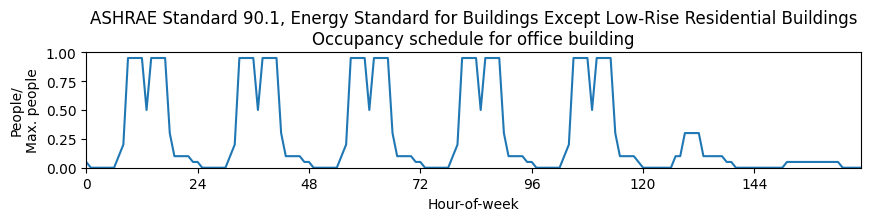

In [5]:
fig = plot_baseline_schedule()
plt.show()

## Questions
---

### Q1: Install EnergyPlus

If you already have EnergyPlus installed, you should skip this question.

To get started, let us install EnergyPlus in the case that you do not already have it installed. The [Introduction to EnergyPlus](https://github.com/intelligent-environments-lab/occupant_centric_grid_interactive_buildings_course/blob/main/src/notebooks/tutorials/introduction_to_energy_plus.ipynb) tutorial has instructions on how to install EnergyPlus in a Colab environment or in your local machine.

__Q1.1:__ Use the next cell to install EnergyPlus if you do not have it installed and want to install it in Colab by copying the installation code for Colab in the the [Introduction to EnergyPlus](https://github.com/intelligent-environments-lab/occupant_centric_grid_interactive_buildings_course/blob/main/src/notebooks/tutorials/introduction_to_energy_plus.ipynb) tutorial:

In [6]:
# TODO: Copy and paste EnergyPlus installation for Colab. 
# Finally, execute this cell to run installation

### Q2: Simulating energy performance from data-driven occupancy schedules

Here we will run the energy performance simulations. 

__Q2.1:__ First, you will need to generate 100 schedules and save them in a `.csv` file. You should reuse the notebook for hw4 and adapt it such that it generates not just one schedule for a year, but 100 schedules. All of them saved into one dataframe for simplicity.

Then, save the dataframe into a `.csv` file that should have 8760 rows representing the number of hours in a year and 100 columns representing the 100 occupancy schedule samples. You can refer to the [example schedules](https://raw.githubusercontent.com/intelligent-environments-lab/occupant_centric_grid_interactive_buildings_course/main/assets/data/homework_5_example_schedules.csv) to see what the structure should look like.

__Q2.2:__ In the following cell, replace the `EXAMPLE_SCHEDULES_URL` with the absolute path to your own schedules file:

In [7]:
# TODO: replace value with your own absolute filepath.
MY_SCHEDULES_ABSOLUTE_FILEPATH = EXAMPLE_SCHEDULES_URL

__Q2.2:__ You will now specify the path to your `Input Data Dictionary` (`IDD`) for you EnergyPlus simulation the next cell. if you installed using Colab, you do not need to do anything in the next cell as the path for a Colab installation was already defined in the `Setting constants and functions` section above. For local installations, a quick Google search will help you locate where yours is located.

In [8]:
# TODO: replace value with your own IDD filepath if simulating outside Colab.
MY_IDD_FILEPATH = DEFAULT_IDD_FILEPATH
assert os.path.isfile(MY_IDD_FILEPATH), f'Provided IDD does not exist: {MY_IDD_FILEPATH}'

__Q2.3:__ Execute the next following cell to run the simulations. 

Note that this might take a while to complete (~4 mins per simulation). The simulation function defined in the `Setting constants and functions` section can run simulations in parallel. In the default Colab environment, two simulation can run at a time completing in ~ 3hrs 30 mins. For local runtime: On an Intel COre i5 MacBook Pro with 16 GB RAM, up to eight simulations can run at a time bringing the runtime down to about 50 mins. Use these times to roughly estimate how long you need to leave your own simulation running.

Also, there will be a lot of printouts while the simulations run about unused schedules. Do not worry about these messages as they do not affect your simulations.

In [ ]:
result_ids_and_directories = simulate(MY_SCHEDULES_ABSOLUTE_FILEPATH, MY_IDD_FILEPATH)

### Q3: Impact of occupancy on total building energy use


__Q3.1:__ The results dataframe has hourly time series of building-level electricity and natural gas energy use. Both of these are in the unit of `kWh` so can be directly added to get the total building energy use for each hour. Use that to calculate the annual total building energy use for each unique simulation run. 

You only need to report the average annual total energy use for all data-driven-schedule simulations and the standard deviation compared to the annual total building energy use when the ASHRAE schedule is used.

In [ ]:
# TODO:
average_annual_total_energy_use_for_data_driven_schedules = None
standard_deviation_of_annual_total_energy_use_for_data_driven_schedules = None
standard_deviation_annual_total_energy_use_for_baseline_ashrae_schedule = None

__Q3.2:__ Leave one comment on how the energy use as a result of the data-driven schedules differs from that of the baseline:

> _write your comment here_

### Q4: Impact of occupancy on cooling and heating loads

__Q4.1:__ The results dataframe has building-level hourly cooling and heating loads time series as well as hourly occupant counts. Using these data, how is occupancy impacting cooling and heating loads? Discuss with appropriate visualization(s).

In [ ]:
# TODO: use simulation results to answer question above

> _write your discussion here_